In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import talib as ta
import datetime, time
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from tqdm import tqdm_notebook
from scipy.stats import mstats

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

In [4]:
def calc_exf(df):
    ret = df.ret_p1
    dret = df.dret_p1
    pre_mv = df.mv.shift(1) * df.retx_p1
    exf = df.mv - pre_mv
    exf_to_mv = exf / df.mv.shift(1)
    
    ret_roll_1 = ((ret[::-1]).rolling(1, min_periods=1).apply(np.prod, raw=True)[::-1])
    ret_roll_2 = ((ret[::-1]).rolling(2, min_periods=1).apply(np.prod, raw=True)[::-1])
    ret_roll_3 = ((ret[::-1]).rolling(3, min_periods=1).apply(np.prod, raw=True)[::-1])
    ret_roll_4 = ((ret[::-1]).rolling(4, min_periods=1).apply(np.prod, raw=True)[::-1])
    ret_roll_5 = ((ret[::-1]).rolling(5, min_periods=1).apply(np.prod, raw=True)[::-1])
    ret_roll_6 = ((ret[::-1]).rolling(6, min_periods=1).apply(np.prod, raw=True)[::-1])
    ret_roll_7 = ((ret[::-1]).rolling(7, min_periods=1).apply(np.prod, raw=True)[::-1])
    ret_roll_8 = ((ret[::-1]).rolling(8, min_periods=1).apply(np.prod, raw=True)[::-1])
    
    dret_roll_1 = ((dret[::-1]).rolling(1, min_periods=1).apply(np.prod, raw=True)[::-1])
    dret_roll_2 = ((dret[::-1]).rolling(2, min_periods=1).apply(np.prod, raw=True)[::-1])
    dret_roll_3 = ((dret[::-1]).rolling(3, min_periods=1).apply(np.prod, raw=True)[::-1])
    dret_roll_4 = ((dret[::-1]).rolling(4, min_periods=1).apply(np.prod, raw=True)[::-1])
    dret_roll_5 = ((dret[::-1]).rolling(5, min_periods=1).apply(np.prod, raw=True)[::-1])
    dret_roll_6 = ((dret[::-1]).rolling(6, min_periods=1).apply(np.prod, raw=True)[::-1])
    dret_roll_7 = ((dret[::-1]).rolling(7, min_periods=1).apply(np.prod, raw=True)[::-1])
    dret_roll_8 = ((dret[::-1]).rolling(8, min_periods=1).apply(np.prod, raw=True)[::-1])
    
    # 参考99页，引用7，这里要求的是从1974开始
    dret_roll_1_bar = dret_roll_1.shift(-1).mean()
    dret_roll_2_bar = dret_roll_2.shift(-1).mean()
    dret_roll_3_bar = dret_roll_3.shift(-1).mean()
    dret_roll_4_bar = dret_roll_4.shift(-1).mean()
    dret_roll_5_bar = dret_roll_5.shift(-1).mean()
    
    car1 = ret_roll_1 - dret_roll_1
    car2 = ret_roll_2 - dret_roll_2
    car3 = ret_roll_3 - dret_roll_3
    car4 = ret_roll_4 - dret_roll_4
    car5 = ret_roll_5 - dret_roll_5
    car6 = ret_roll_6 - dret_roll_6
    car7 = ret_roll_7 - dret_roll_7
    car8 = ret_roll_8 - dret_roll_8
    
    wr1 = ret_roll_1 / dret_roll_1
    wr2 = ret_roll_2 / dret_roll_2
    wr3 = ret_roll_3 / dret_roll_3
    wr4 = ret_roll_4 / dret_roll_4
    wr5 = ret_roll_5 / dret_roll_5
    
    wr1_bar = ret_roll_1 / dret_roll_1_bar
    wr2_bar = ret_roll_2 / dret_roll_2_bar
    wr3_bar = ret_roll_3 / dret_roll_3_bar
    wr4_bar = ret_roll_4 / dret_roll_4_bar
    wr5_bar = ret_roll_5 / dret_roll_5_bar
    
    res = pd.DataFrame({
        'date':df.date,
        'mv':df.mv,
        'pre_mv':pre_mv,
        'retx_p1':df.retx_p1,
        'exf':exf,
        'exf_to_mv':exf_to_mv,
        
        'car1':car1.shift(-1),
        'car3':car3.shift(-1),
        'car5':car5.shift(-1),
        
        'wr1':wr1.shift(-1),
        'wr2':wr2.shift(-1),
        'wr3':wr3.shift(-1),
        'wr4':wr4.shift(-1),
        'wr5':wr5.shift(-1),
        
        'wr1_bar':wr1_bar.shift(-1),
        'wr2_bar':wr2_bar.shift(-1),
        'wr3_bar':wr3_bar.shift(-1),
        'wr4_bar':wr4_bar.shift(-1),
        'wr5_bar':wr5_bar.shift(-1),
        
        'ret_n1':ret.shift(-1)-1,
        'ret_n2':ret.shift(-2)-1,
        'ret_n3':ret.shift(-3)-1,
        'ret_n4':ret.shift(-4)-1,
        'ret_n5':ret.shift(-5)-1,
        'ret_n6':ret.shift(-6)-1,
        'ret_n7':ret.shift(-7)-1,
        'ret_n8':ret.shift(-8)-1
        
    })
    return res

load data

In [5]:
crsp_fa = pd.read_csv('data/crsp_fa_filtered.zip',
                     parse_dates=['date'], infer_datetime_format=True)

In [6]:
# 运行此代码后，市值将被替换成调整后的市值
crsp_fa.mv = crsp_fa.mv_adj

In [7]:
crsp_filter = crsp_fa.set_index('date')[:'2008']
filter_permno = crsp_filter[(crsp_filter.mv_adj.shift(1) * crsp_filter.retx_p1) >= 5e+4].\
permno.unique().tolist()
crsp_fa_filtered = crsp_fa.set_index('permno').loc[filter_permno].reset_index()

In [8]:
tic = time.perf_counter()
result_exf = crsp_fa_filtered.set_index('permno').groupby('permno').apply(calc_exf)
toc = time.perf_counter()
print(toc-tic)

382.1149283


In [9]:
res1 = result_exf.copy()
res1 = res1.dropna(subset=['exf_to_mv']) # 只是剔除exf_to_mv中的异常值
res1 = res1.reset_index().set_index('date')[:'2008'] # 筛选出到08年的数据
res1.exf_to_mv = mstats.winsorize(res1.exf_to_mv, limits=[0.01, 0.01]) # 这里也可以调整

per = np.linspace(0,1,11).tolist()
bins = res1.describe(percentiles=per).exf_to_mv.iloc[4:-1].tolist()
bins = [bins[0]-1] + bins[1:]

我先用pre_mv将就一下

In [13]:
res1.pre_mv.sum()

303757857865.07098

In [19]:
res1['ret_n%d' % 1].sum()

31037.916115863354

In [17]:
def factor_analysis(df):
    total_mv = df.mv.sum()
    ret_dict = {}
    for i in range(1, 9):
        ret_dict['ret_n%d' % i] = (df['ret_n%d' % i] * df.mv / total_mv).sum()
    return pd.DataFrame(ret_dict, index=[df.exf_to_mv.mean()])

In [18]:
res1_grouped = res1.groupby(pd.cut(res1.exf_to_mv,bins, right=True)).\
apply(factor_analysis)
res1_grouped.index = list(range(1,11))
res1_grouped.index.name = 'decile'

In [19]:
bar_cols = ['ret_n1', 'ret_n2', 'ret_n3', 'ret_n4', 'ret_n5', 'ret_n6',
       'ret_n7', 'ret_n8']

In [21]:
res1_grouped_transfer = res1_grouped[bar_cols].T
res1_grouped_transfer = res1_grouped_transfer.assign(decile_diff = \
                        res1_grouped_transfer[1]-res1_grouped_transfer[10])

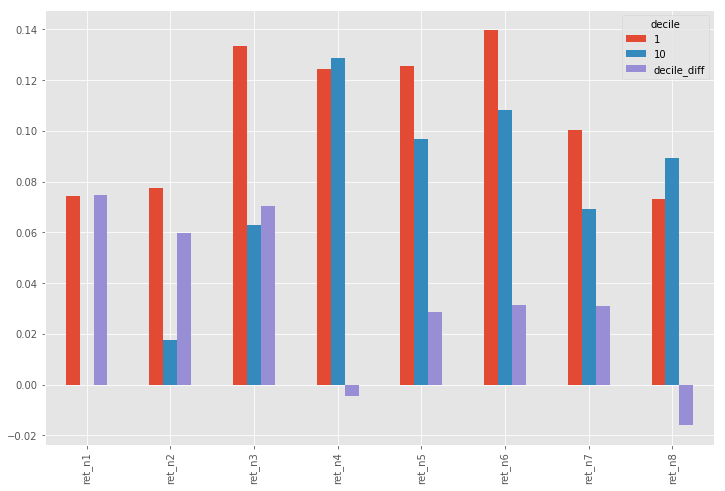

In [22]:
res1_grouped_transfer[[1, 10, 'decile_diff']].plot.bar();

为了按照每年进行分组计算，先添加year字段

In [25]:
# 进行复制操作，避免破坏数据
res1 = result_exf.copy()
res1 = res1.reset_index().set_index('date')[:'2008'] # 筛选出到08年的数据
res1.exf_to_mv = mstats.winsorize(res1.exf_to_mv, limits=[0.01, 0.01]) 
res1 = res1.dropna(subset=['exf_to_mv'])
res1 = res1.reset_index()
res1 = res1.assign(year = res1.date.dt.year)
def group_calc(g):
#     g.exf_to_mv = mstats.winsorize(g.exf_to_mv, limits=[0.05, 0.05])
    per = np.linspace(0,1,11).tolist()
    bins = g.describe(percentiles=per).exf_to_mv.iloc[4:-1].tolist()
    bins = [bins[0]-1] + bins[1:]
    res = g.groupby(pd.cut(g.exf_to_mv,bins, right=True)).apply(factor_analysis)
    res.index = list(range(1,11))
    res.index.name = 'decile'
    return res

In [26]:
res2 = res1.groupby('year').apply(group_calc)

In [27]:
res2_grouped = res2.groupby('decile').mean()
res2_grouped.index.name = 'decile'

In [28]:
res2_grouped_transfer = res2_grouped[bar_cols].T
res2_grouped_transfer = res2_grouped_transfer.assign(decile_diff = \
                        res2_grouped_transfer[1]-res2_grouped_transfer[10])

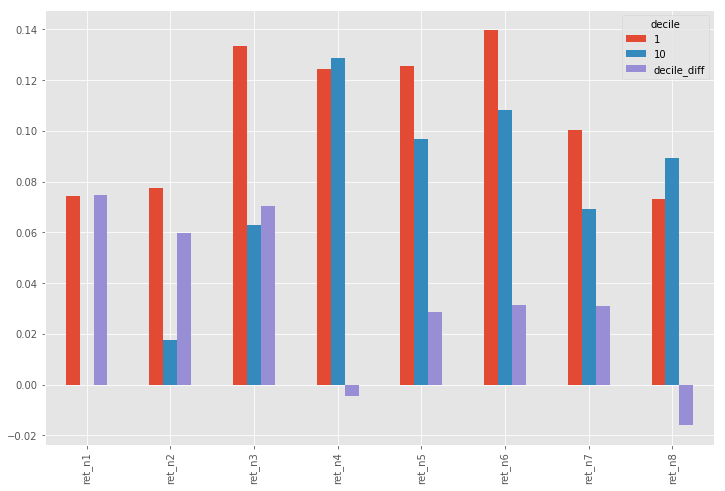

In [29]:
res1_grouped_transfer[[1, 10, 'decile_diff']].plot.bar();